In [ ]:
# imports

import json
import time
from pathlib import Path
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from pathlib import Path
import json
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed


In [2]:
# prepare paths

root_dir = Path("..")

results_dir = root_dir / 'results'
predictions_dir = results_dir / 'predictions'

summary_csv_path = results_dir / 'summary.csv'
dataset_path = root_dir / 'notebook' / 'data' / 'test_dataset.json'
chart_path = results_dir / 'comparison_chart.png'

In [3]:
# load all 4 methods into memory
%run ./03_interactive.ipynb

In [4]:
# create local methods and parameters for easier handling

def call_embedding(code: str, top_k = 10):
    return detect_embedding(code, top_k = top_k)

def call_llm(code, top_n = 25):
    return detect_llm(code, top_n = top_n)

def call_rag(code: str, top_k = 5):
    return detect_rag(code, top_k = top_k)

def call_hybrid_rag(code, top_k_dense = 5, top_k_bm25 = 5, top_k_fused = 5, w_dense = 0.5):
    return detect_hybrid_rag(
        code,
        top_k_dense = top_k_dense,
        top_k_bm25 = top_k_bm25,
        top_k_fused = top_k_fused,
        w_dense = w_dense
    )

In [5]:
# load dataset

@dataclass
class CodeSample:
    id: str
    query_code: str
    is_positive: bool
    source_hint: str
    notes: str

def load_dataset(dataset_path):
    with open(dataset_path, 'r', encoding = 'utf-8') as f:
        data = json.load(f)
        
    return [CodeSample(**item) for item in data]

dataset = load_dataset(dataset_path)

In [6]:
# prepare methods and parameter combinations

methods = {
    "pure_embedding": call_embedding,
    "direct_llm": call_llm,
    "rag": call_rag,
    "hybrid_rag": call_hybrid_rag
}

embedding_param_grid = [
    {"top_k": 3},
    {"top_k": 5},
    {"top_k": 10},
    {"top_k": 20},
    {"top_k": 50}
]

direct_llm_param_grid = [
    {"top_n": 5},
    {"top_n": 10},
    {"top_n": 25},
    {"top_n": 50}
]

rag_param_grid = [
    {"top_k": 1},
    {"top_k": 5},
    {"top_k": 10}
]

# for hybrid RAG:
# weights and top_k_fused are more important and interesting so I'll only vary them
# or else I'll run out of money :)
hybrid_rag_param_grid = []

# 5 * 3 = 15 hybrid_rag cases in total
for w in [0.2, 0.5, 0.8]:
    for k_fused in [1, 5, 10]:
        hybrid_rag_param_grid.append(
            {
                "top_k_dense": 5,
                "top_k_bm25": 5,
                "top_k_fused": k_fused,
                "w_dense": w
            }
        )

param_grids = {
    "pure_embedding": embedding_param_grid,
    "direct_llm": direct_llm_param_grid,
    "rag": rag_param_grid,
    "hybrid_rag": hybrid_rag_param_grid
}

In [12]:
# function to run method with specific parameters on dataset

@dataclass
class EvaluationRow:
    method: str
    config_name: str
    id: str
    is_positive: bool
    is_plagiarized: bool
    reason: str
    evidence_mine: any
    evidence_oai: any
    ms_elapsed: float

def run_evaluation_config(method_name, params, dataset):
    rows = []
    func = methods[method_name]

    if params:
        parts = []
        for k, v in params.items():
            val = str(v).replace(".", "_")
            parts.append(f"{k}-{val}")
        config_str = "_".join(parts)
    else:
        config_str = "noparams"

    for sample in dataset:
        start_time = time.time()
        result = func(sample.query_code, **params)
        end_time = time.time()

        row = EvaluationRow(
            method = method_name,
            config_name = config_str,
            id = sample.id,
            is_positive = sample.is_positive,
            is_plagiarized = result.is_plagiarized,
            reason = result.reason,
            evidence_mine = result.evidence_mine,
            evidence_oai = result.evidence_oai,
            ms_elapsed = (end_time - start_time) * 1000
        )

        rows.append(row)

    print(f"{method_name} with configuration {config_str} finished")
    return rows

In [13]:
# function to save results

def save_config_results(method_name, config_name, rows):
    df = pd.DataFrame([asdict(r) for r in rows])
    file_path = predictions_dir / method_name / f"{config_name}.csv"
    file_path.parent.mkdir(parents = True, exist_ok = True)
    df.to_csv(file_path, index = False)

In [ ]:
# run all methods with all parameters combinations
# this notebook segment alone was taking 15+ minutes, so I made it parallel

all_ablation_rows = []
tasks = []

with ThreadPoolExecutor(max_workers = 3) as executor: # calling LLM API with threads may result in RateLimit error depending on model. If so, decrease max_workers.
    for method_name, func in methods.items():
        grid = param_grids.get(method_name, [{}])

        for params in grid:
            future = executor.submit(run_evaluation_config, method_name, params, dataset)
            tasks.append(future)

    for future in as_completed(tasks):
        rows = future.result()
        if not rows:
            continue
        
        method_name_thread_safe = rows[0].method
        config_name = rows[0].config_name
        save_config_results(method_name_thread_safe, config_name, rows)
        all_ablation_rows.extend(rows)

ablations_df = pd.DataFrame([asdict(r) for r in all_ablation_rows])
ablations_path = predictions_dir / "ablations_all.csv"
ablations_df.to_csv(ablations_path, index = False)

print("All ablation configurations finished and saved")


pure_embedding with configuration top_k-20 finished
pure_embedding with configuration top_k-3 finished
pure_embedding with configuration top_k-5 finished
pure_embedding with configuration top_k-10 finished
pure_embedding with configuration top_k-50 finished
direct_llm with configuration top_n-25 finished
direct_llm with configuration top_n-5 finished
direct_llm with configuration top_n-10 finished
direct_llm with configuration top_n-50 finished
rag with configuration top_k-5 finished
rag with configuration top_k-1 finished
rag with configuration top_k-10 finished
hybrid_rag with configuration top_k_dense-5_top_k_bm25-5_top_k_fused-1_w_dense-0_2 finished
hybrid_rag with configuration top_k_dense-5_top_k_bm25-5_top_k_fused-5_w_dense-0_2 finished
hybrid_rag with configuration top_k_dense-5_top_k_bm25-5_top_k_fused-10_w_dense-0_2 finished
hybrid_rag with configuration top_k_dense-5_top_k_bm25-5_top_k_fused-1_w_dense-0_5 finished
hybrid_rag with configuration top_k_dense-5_top_k_bm25-5_top_

In [15]:
# functions to evaluate results using metrics

def confusion_counts(dataframe):
    tp = int(((dataframe.is_positive == True) & (dataframe.is_plagiarized == True)).sum())
    fp = int(((dataframe.is_positive == False) & (dataframe.is_plagiarized == True)).sum())
    tn = int(((dataframe.is_positive == False) & (dataframe.is_plagiarized == False)).sum())
    fn = int(((dataframe.is_positive == True) & (dataframe.is_plagiarized == False)).sum())
    return tp, fp, tn, fn

def calculate_metrics(true_positive, false_positive, true_negative, false_negative):
    # precision = how often a detected plagiarism case was really a plagiarism
    assumed_plagiarized_cnt = true_positive + false_positive
    precision = true_positive / assumed_plagiarized_cnt if assumed_plagiarized_cnt > 0 else 0.0

    # recall = how many real plagiarism cases the model caught
    total_plagiarized_cnt = true_positive + false_negative
    recall = true_positive / total_plagiarized_cnt if total_plagiarized_cnt > 0 else 0.0

    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    accuracy = (true_positive + true_negative) / max(true_positive + false_positive + true_negative + false_negative, 1)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }

In [16]:
summary_rows = []
grouped_ablations = ablations_df.groupby("config_name")

for (method_name, config_name), df in ablations_df.groupby(["method", "config_name"]):
    tp, fp, tn, fn = confusion_counts(df)
    scores = calculate_metrics(tp, fp, tn, fn)
    avg_ms = float(df["ms_elapsed"].mean()) if len(df) else 0.0

    def get_param(col):
        return df[col].dropna().iloc[0] if col in df.columns and df[col].notna().any() else None

    summary_rows.append({
        "method": method_name,
        "config_name": config_name,
        "n": int(len(df)),
        "tp": tp,
        "fp": fp,
        "tn": tn,
        "fn": fn,
        "precision": scores["precision"],
        "recall": scores["recall"],
        "f1": scores["f1"],
        "accuracy": scores["accuracy"],
        "avg_ms": avg_ms
    })

summary = (
    pd.DataFrame(summary_rows)
    .assign(method = pd.Categorical( # keep same order as in code for structure
        pd.DataFrame(summary_rows)["method"],   
        categories = methods,
        ordered = True
    ))
    .sort_values(["method", "f1", "avg_ms"], ascending = [True, True, True])
    .reset_index(drop = True)
)

summary.to_csv(summary_csv_path, index = False)

C:\Users\Giorgi\AppData\Local\Temp\ipykernel_9232\3483888909.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("method")


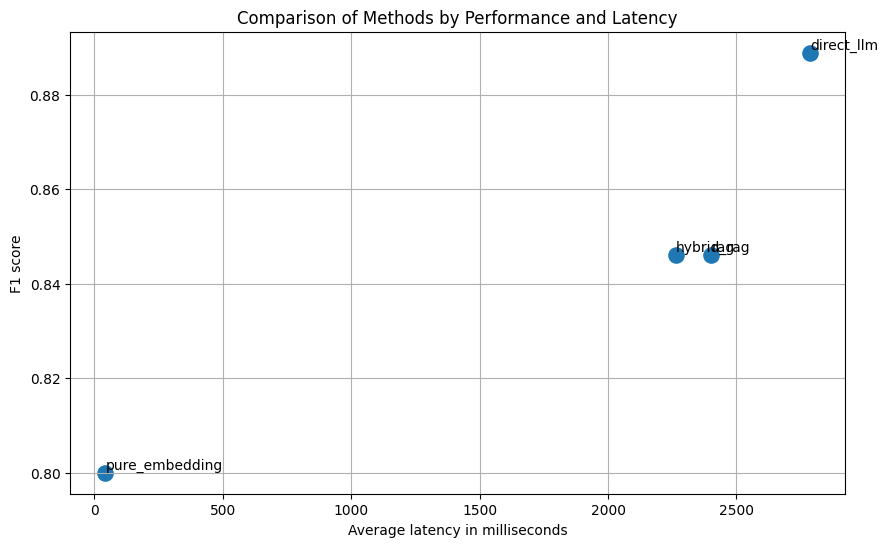

Saved comparison chart to: ..\results\comparison_chart.png


In [25]:
# create a comparison visualization of all four methods and save as PNG

import matplotlib.pyplot as plt

best_per_method = (
    summary.sort_values("f1", ascending=False)
           .groupby("method")
           .first()
           .reset_index()
)

plt.figure(figsize=(10, 6))

# scatter plot: X = avg_ms, Y = f1
plt.scatter(
    best_per_method["avg_ms"],
    best_per_method["f1"],
    s=120
)

# label each point
for _, row in best_per_method.iterrows():
    plt.text(
        row["avg_ms"],
        row["f1"],
        row["method"],
        fontsize=10,
        ha="left",
        va="bottom"
    )

plt.xlabel("Average latency in milliseconds")
plt.ylabel("F1 score")
plt.title("Comparison of Methods by Performance and Latency")
plt.grid(True)
plt.show()

plt.savefig(chart_path, dpi=200, bbox_inches="tight")
plt.close()

print(f"Saved comparison chart to: {chart_path}")

In [ ]:
# Explanation of results:

# The numbers show how each method performed on both positive and negative samples.
# Positive samples represent real plagiarism. Negative samples are clean code that should not be flagged.

# Embedding only:
# It handled negative cases quite well. False positives were low, which means it rarely flagged clean code by mistake.
# However it missed the most positive cases, so recall was relatively low compared to other methods
# This produced stable but moderate f1 values. 
# On the pro side, it was of course the fastest method, since index is saved locally.

# Direct LLM:
# All negative cases were identified correctly.
# It caught more positive cases than embeddings in several configurations. This improved recall.
# It was slower because every decision required a fresh LLM API call.

# RAG:
# All negative cases were identified correctly, again.
# With low k, it sometimes missed positives but also avoided false positives.
# With higher k, it saw more context and caught more positives, but took more time.
# Its speed is similar to direct LLM since BM25 index is also stored, and LLM calls took ~same time.

# Hybrid RAG:
# Worked well on negative cases too.
# The combination of dense and sparse retrieval helped filter out irrelevant content,
# It also found more positives than the embedding only method.
# Runtime is similar because of LLM calls.

# Overall:
# - Embeddings: low false positives, missed the most positives, but fastest.
# - Direct LLM: higher recall, more false positives when top_n grows.
# - RAG: retrieval depth shifts the balance between misses and false alarms.
# - Hybrid RAG: stronger balance across both sides, often best tradeoff between catching positives and avoiding incorrect flags.

# Of course it would work better with higher sample size, but each run already costs ~$0.25 :(
